# Preprocessing Transforms Gallery

In PathML, preprocessing pipelines are created by composing modular ``Transforms``.

The following tutorial contains an overview of the PathML pre-processing Transforms, with examples.

We will divide Transforms into three primary categories, depending on their function:

1. Transforms that modify an image
    - Gaussian Blur
    - Median Blur
    - Box Blur
    - Stain Normalization
    - Superpixel Interpolation
2. Transforms that create a mask
    - Nucleus Detection
    - Binary Threshold
3. Transforms that modify a mask
    - Morphological Closing
    - Morphological Opening
    - Foreground Detection
    - Tissue Detection

In [1]:
import matplotlib.pyplot as plt
import copy

from pathml.core import HESlide, Tile
from pathml.utils import plot_mask, RGB_to_GREY
from pathml.preprocessing import (
    BoxBlur, GaussianBlur, MedianBlur,
    NucleusDetectionHE, StainNormalizationHE, SuperpixelInterpolation,
    ForegroundDetection, TissueDetectionHE, BinaryThreshold,
    MorphClose, MorphOpen
)

fontsize = 14

Note that a ``Transform`` operates on ``Tile`` objects. We must first load a whole-slide image, extract a smaller region, and create a ``Tile``:

In [2]:
wsi = HESlide("./../data/CMU-1-Small-Region.svs")
region = wsi.slide.extract_region(location = (900, 800), size = (500, 500))

def smalltile():
    # convenience function to create a new tile
    return Tile(region, coords = (0, 0), name = "testregion", slidetype=type(wsi))

## Transforms that modify an image

### Blurring Transforms

We'll start with the 3 blurring transforms: ``GaussianBlur``, ``MedianBlur``, and ``BoxBlur``

Blurriness can be control with the ``kernel_size`` parameter. A larger kernel width yields a more blurred result for all blurring transforms:

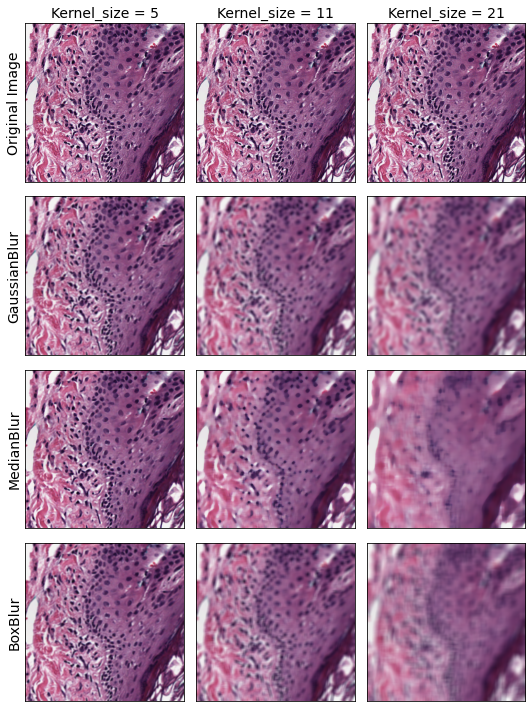

In [3]:
blurs = ["Original Image", GaussianBlur, MedianBlur, BoxBlur]
blur_name = ["Original Image", "GaussianBlur", "MedianBlur", "BoxBlur"]
k_size = [5, 11, 21]
fig, axarr = plt.subplots(nrows=4, ncols=3, figsize=(7.5, 10))
for i, blur in enumerate(blurs):
    for j, kernel_size in enumerate(k_size):
        tile = smalltile()
        if blur != "Original Image":
            b = blur(kernel_size = kernel_size)
            b.apply(tile)
        ax = axarr[i, j]
        ax.imshow(tile.image)
        if i == 0:
            ax.set_title(f"Kernel_size = {kernel_size}", fontsize=fontsize)  
        if j == 0:
            ax.set_ylabel(blur_name[i], fontsize = fontsize)        
for a in axarr.ravel():
    a.set_xticks([])
    a.set_yticks([])
plt.tight_layout()
plt.show() 

### Superpixel Interpolation

Superpixel interpolation is a method for grouping together nearby similar pixels to form larger "superpixels."
The ``SuperpixelInterpolation`` Transform divides the input image into superpixels using SLIC algorithm, then interpolates each superpixel with average color. The ``region_size`` parameter controls how big the superpixels are:

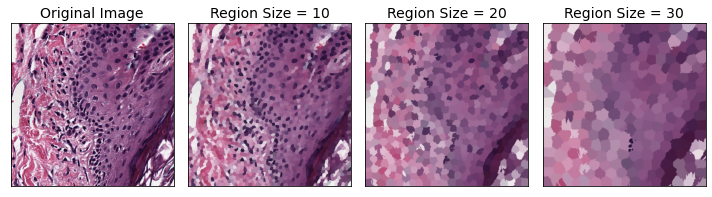

In [4]:
region_sizes = ["original", 10, 20, 30]
fig, axarr = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
for i, region_size in enumerate(region_sizes):
    tile = smalltile()
    if region_size == "original":
        axarr[i].set_title("Original Image", fontsize = fontsize)
    else:
        t = SuperpixelInterpolation(region_size = region_size)
        t.apply(tile)
        axarr[i].set_title(f"Region Size = {region_size}", fontsize = fontsize)
    axarr[i].imshow(tile.image)
for ax in axarr.ravel():
    ax.set_yticks([])
    ax.set_xticks([])
plt.tight_layout()
plt.show()

### Stain Normalization 

H&E images are a combination of two stains: hematoxylin and eosin.
Stain deconvolution methods attempt to estimate the relative contribution of each stain for each pixel.
Each stain can then be pulled out into a separate image, and the deconvolved images can then be recombined to normalize the appearance of the image. 

The ``StainNormalizationHE`` Transform implements two algorithms for stain deconvolution.

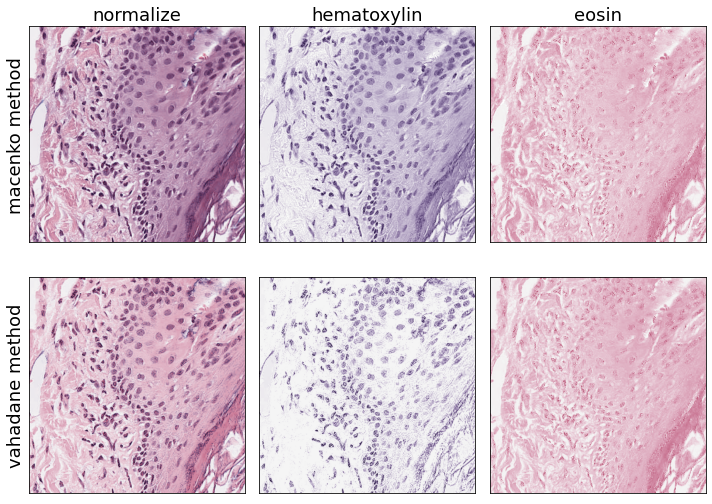

In [5]:
fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=(10, 7.5))
fontsize = 18
for i, method in enumerate(["macenko", "vahadane"]):
    for j, target in enumerate(["normalize", "hematoxylin", "eosin"]):
        tile = smalltile()
        normalizer = StainNormalizationHE(target = target, stain_estimation_method = method)
        normalizer.apply(tile)
        ax = axarr[i, j]
        ax.imshow(tile.image)
        if j == 0:
            ax.set_ylabel(f"{method} method", fontsize=fontsize)
        if i == 0:
            ax.set_title(target, fontsize = fontsize)
for a in axarr.ravel():
    a.set_xticks([])
    a.set_yticks([])
plt.tight_layout()
plt.show()

## Transforms that create a mask

### Binary Threshold

The ``BinaryThreshold`` transform creates a mask by classifying whether each pixel is above or below the given threshold.
Note that you can supply a ``threshold`` parameter, or use Otsu's method to automatically determine a threshold:

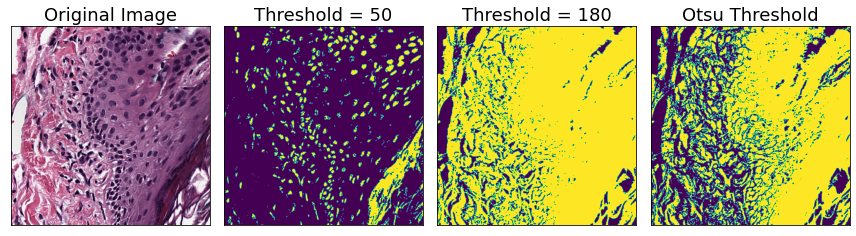

In [6]:
thresholds = ["original", 50, 180, "otsu"]
fig, axarr = plt.subplots(nrows=1, ncols=len(thresholds), figsize=(12, 6))
for i, thresh in enumerate(thresholds):
    tile = smalltile()
    if thresh == "original":
        axarr[i].set_title("Original Image", fontsize = fontsize)
        axarr[i].imshow(tile.image)
    elif thresh == "otsu":
        t = BinaryThreshold(mask_name = "binary_threshold", 
                            inverse = True, use_otsu = True)
        t.apply(tile)
        axarr[i].set_title(f"Otsu Threshold", fontsize = fontsize)
        axarr[i].imshow(tile.masks["binary_threshold"])
    else:
        t = BinaryThreshold(mask_name = "binary_threshold", threshold = thresh, 
                            inverse = True, use_otsu = False)
        t.apply(tile)
        axarr[i].set_title(f"Threshold = {thresh}", fontsize = fontsize)
        axarr[i].imshow(tile.masks["binary_threshold"])
for ax in axarr.ravel():
    ax.set_yticks([])
    ax.set_xticks([])
plt.tight_layout()
plt.show()

### Nucleus Detection

The ``NucleusDetectionHE`` transform employs a simple nucleus detection algorithm for H&E stained images. It works by first separating hematoxylin channel, then doing interpolation using superpixels, and finally using Otsu’s method for binary thresholding. This is an example of a compound Transform created by combining several other Transforms:

/opt/miniconda3/envs/pathml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/pathml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


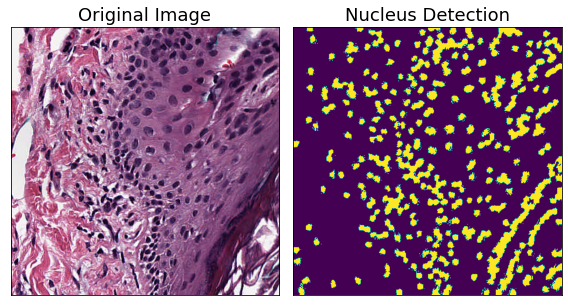

In [7]:
tile = smalltile()
nucleus_detection = NucleusDetectionHE(mask_name = "detect_nuclei")
nucleus_detection.apply(tile)

fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
axarr[0].imshow(tile.image)
axarr[0].set_title("Original Image", fontsize=fontsize)
axarr[1].imshow(tile.masks["detect_nuclei"])
axarr[1].set_title("Nucleus Detection", fontsize=fontsize)
for ax in axarr.ravel():
    ax.set_yticks([])
    ax.set_xticks([])
plt.tight_layout()
plt.show()

We can also overlay the results on the original image to see which regions were identified as being nuclei:

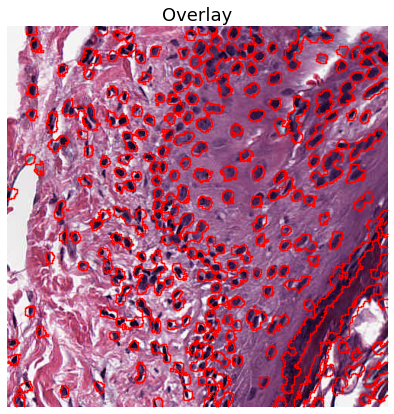

In [8]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_mask(im = tile.image, mask_in=tile.masks["detect_nuclei"], ax = ax)
plt.title("Overlay", fontsize = fontsize)
plt.axis('off')
plt.show()

## Transforms that modify a mask

For the following transforms, we'll use a Tile containing a larger region extracted from the slide.

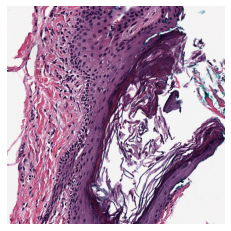

In [9]:
bigregion = wsi.slide.extract_region(location = (800, 800), size = (1000, 1000))

def bigtile():
    # convenience function to create a new tile with a binary mask
    bigtile = Tile(bigregion, coords = (0, 0), name = "testregion", slidetype=type(wsi))
    BinaryThreshold(mask_name = "binary_threshold", inverse=True,
                    threshold = 100, use_otsu = False).apply(bigtile)
    return bigtile

plt.imshow(bigregion)
plt.axis("off")
plt.show()

### Morphological Opening

Morphological opening reduces noise in a binary mask by first applying binary erosion *n* times, and then applying binary dilation *n* times. The effect is to remove small objects from the background. The strength of the effect can be controlled by setting *n*

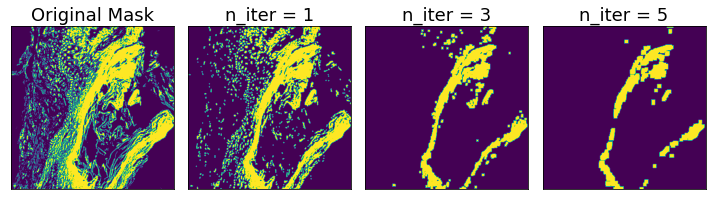

In [10]:
ns = ["Original Mask", 1, 3, 5]
fig, axarr = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
for i, n in enumerate(ns):
    tile = bigtile()
    if n == "Original Mask":
        axarr[i].set_title("Original Mask", fontsize = fontsize)
    else:
        t = MorphOpen(mask_name = "binary_threshold", n_iterations=n)
        t.apply(tile)
        axarr[i].set_title(f"n_iter = {n}", fontsize = fontsize)
    axarr[i].imshow(tile.masks["binary_threshold"])
for ax in axarr.ravel():
    ax.set_yticks([])
    ax.set_xticks([])
plt.tight_layout()
plt.show()

### Morphological Closing

Morphological closing is similar to opening, but in the opposite order: first, binary dilation is applied *n* times, then binary erosion is applied *n* times. The effect is to reduce noise in a binary mask by closing small holes in the foreground. The strength of the effect can be controlled by setting *n*

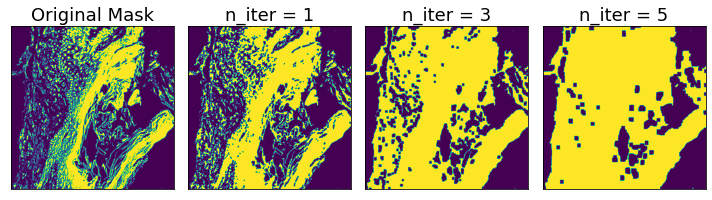

In [11]:
ns = ["Original Mask", 1, 3, 5]
fig, axarr = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
for i, n in enumerate(ns):
    tile = bigtile()
    if n == "Original Mask":
        axarr[i].set_title("Original Mask", fontsize = fontsize)
    else:
        t = MorphClose(mask_name = "binary_threshold", n_iterations=n)
        t.apply(tile)
        axarr[i].set_title(f"n_iter = {n}", fontsize = fontsize)
    axarr[i].imshow(tile.masks["binary_threshold"])
for ax in axarr.ravel():
    ax.set_yticks([])
    ax.set_xticks([])
plt.tight_layout()
plt.show()

### Foreground Detection

This transform operates on binary masks and identifies regions that have a total area greater than specified threshold. Supports including holes within foreground regions, or excluding holes above a specified area threshold.

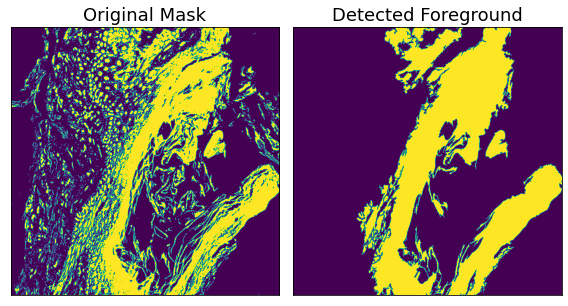

In [12]:
tile = bigtile()
foreground_detector = ForegroundDetection(mask_name = "binary_threshold")
original_mask = tile.masks["binary_threshold"].copy()
foreground_detector.apply(tile)

fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
axarr[0].imshow(original_mask)
axarr[0].set_title("Original Mask", fontsize=fontsize)
axarr[1].imshow(tile.masks["binary_threshold"])
axarr[1].set_title("Detected Foreground", fontsize=fontsize)
for ax in axarr.ravel():
    ax.set_yticks([])
    ax.set_xticks([])
plt.tight_layout()
plt.show()

### Tissue Detection

``TissueDetectionHE`` is a Transform for detecting regions of tissue from an H&E image.
It is composed by applying a sequence of other Transforms: first a median blur, then binary thresholding, then morphological opening and closing, and finally foreground detection.

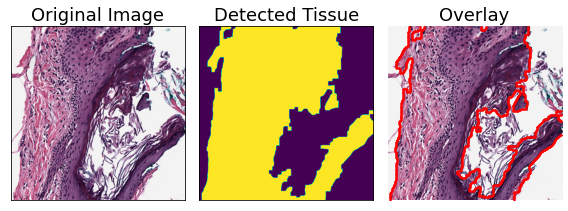

In [13]:
tile = bigtile()

tissue_detector = TissueDetectionHE(mask_name = "tissue", outer_contours_only=True)
tissue_detector.apply(tile)

fig, axarr = plt.subplots(nrows=1, ncols=3, figsize=(8, 8))
axarr[0].imshow(tile.image)
axarr[0].set_title("Original Image", fontsize=fontsize)
axarr[1].imshow(tile.masks["tissue"])
axarr[1].set_title("Detected Tissue", fontsize=fontsize)
plot_mask(im = tile.image, mask_in=tile.masks["tissue"], ax = axarr[2])
axarr[2].set_title("Overlay", fontsize=fontsize)

for ax in axarr.ravel():
    ax.set_yticks([])
    ax.set_xticks([])
plt.tight_layout()
plt.show()